## Plot performance of models against underlying price

In [22]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from xgboost import XGBClassifier

sys.path += ['../']
from functions import plot_performace

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams['figure.dpi'] = 600
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 13})
plt.rc('axes', labelsize=16)
plt.rc('axes', titlesize=18)

### BTC Movement

In [23]:
coin = 'btc'

In [24]:
data = pd.read_parquet(f'../../4_eda/{coin}_stationary_data_lagged.parquet.gzip')
data.columns = data.columns.map('_'.join)
data = (data.fillna(method='ffill')
            .fillna(0)
            .replace([np.inf, -np.inf], 0))
targets = pd.read_parquet(f'../../2_data_processing/numeric_data/{coin}_targets.parquet.gzip')
price_data = pd.read_parquet(f'../../2_data_processing/numeric_data/{coin}_price_data.parquet.gzip').iloc[:,0]

In [25]:
with open(f'../../4_eda/{coin}_causality/{coin}_price_log_difference_causality.txt') as f:
    price_log_difference_vars = f.read().splitlines()
X = data[price_log_difference_vars]

X_train = X.head(3424)
X_test = X.tail(800).head(300)
targets_train = targets.head(3424)
targets_test = targets.tail(800).head(300)
price_data_test = price_data.tail(800).head(300)

y_train = (targets_train[f'{coin}_price_log_difference'] > 0) * 1
y_test = (targets_test[f'{coin}_price_log_difference'] > 0) * 1

model_config = {
    'n_estimators': 685,
    'max_depth': 8,
    'learning_rate': 0.25955419,
    'subsample': 0.795862,
    'colsample_bytree': 0.665903,
    'reg_alpha': 0.0011453083,
    'reg_lambda': 0.5402266104,
    'gamma': 0.1493216309,
    'scale_pos_weight': 0.897427831653
}
model = XGBClassifier(**model_config).fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:,1]

In [26]:
y_pred_d = (y_pred >= 0.6) * 1
y_pred_d = pd.Series(y_pred_d, index=X_test.index)

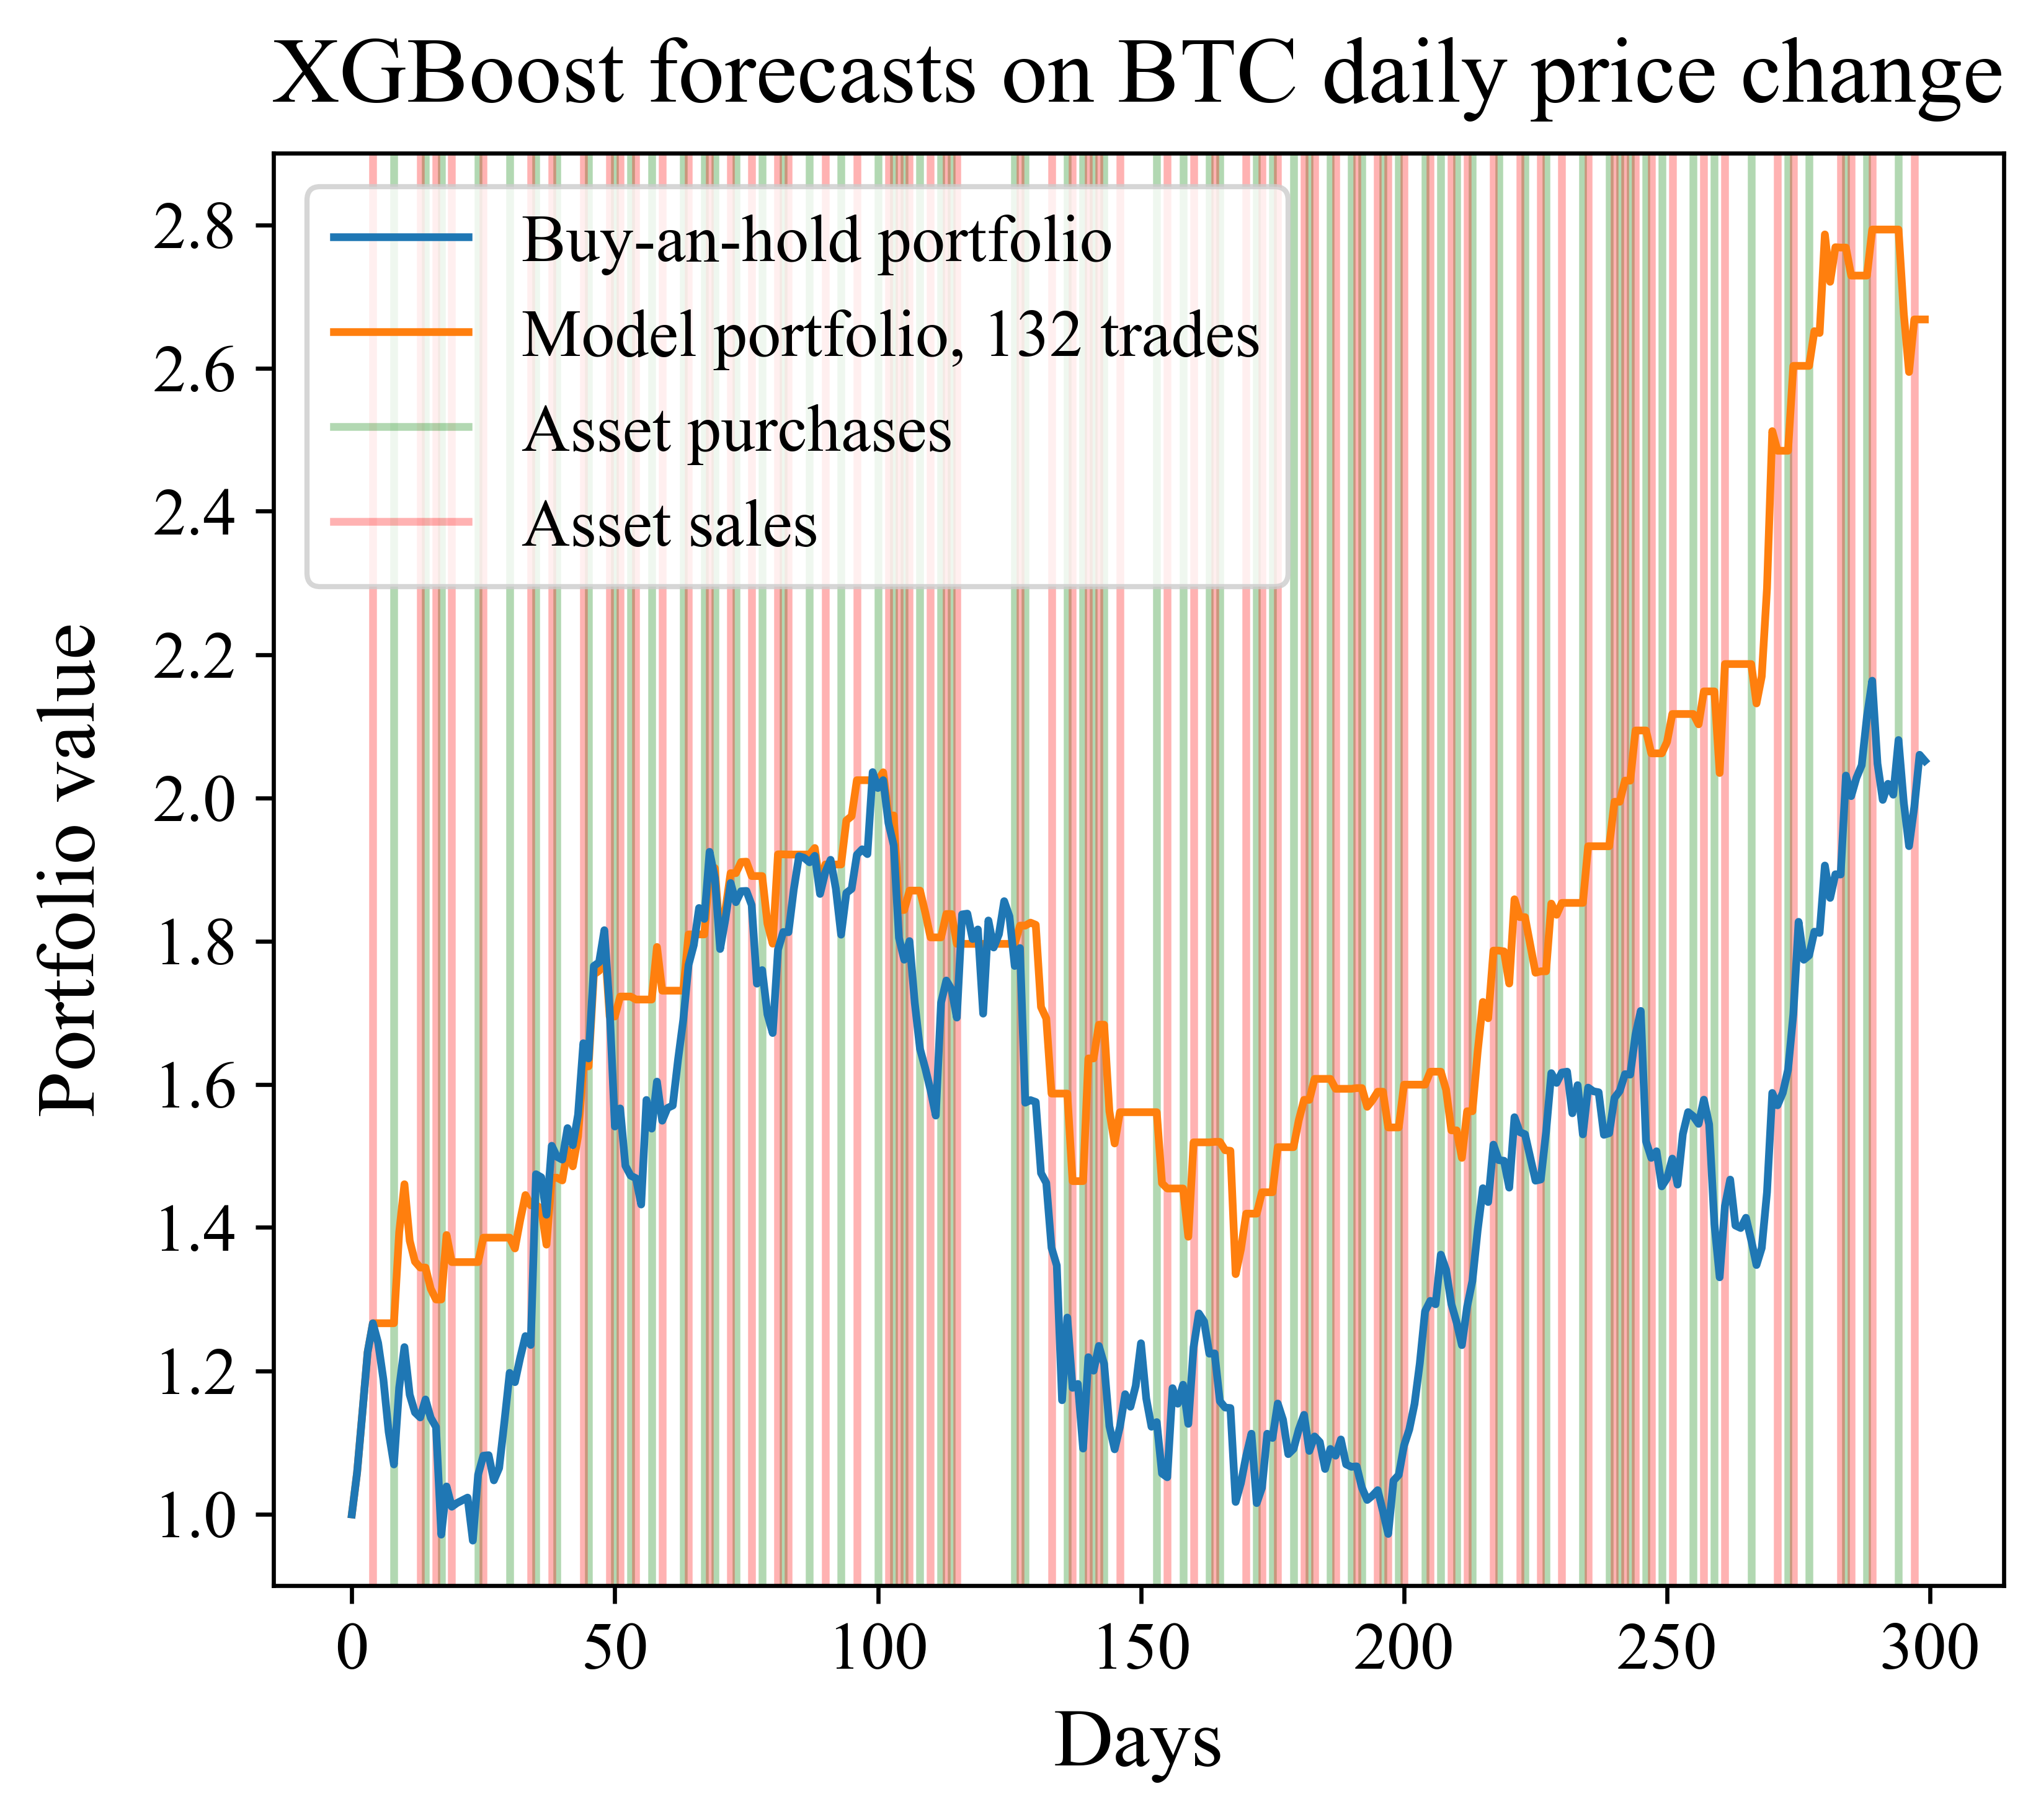

In [27]:
ax = plot_performace(price_data_test, y_pred_d, 'movement')
plt.title('XGBoost forecasts on BTC daily price change', pad=10)

loc = plticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.set_ylim(0.9, 2.9)
plt.show()

### BTC 7d extrema

In [28]:
timeframe = 7

with open(f'../../4_eda/{coin}_causality/{coin}_price_min_{timeframe}d_causality.txt') as f:
    price_min_vars = f.read().splitlines()
with open(f'../../4_eda/{coin}_causality/{coin}_price_max_{timeframe}d_causality.txt') as f:
    price_max_vars = f.read().splitlines()
X_min = data[price_min_vars]
X_max = data[price_max_vars]

X_min_train = X_min.head(3420)
X_min_test = X_min.tail(800).head(300)
X_max_train = X_max.head(3420)
X_max_test = X_max.tail(800).head(300)
targets_train = targets.head(3420)
targets_test = targets.tail(800).head(300)
price_data_test = price_data.tail(800).head(300)

y_min_train = targets_train[f'{coin}_price_min_{timeframe}d']
y_max_train = targets_train[f'{coin}_price_max_{timeframe}d']
y_min_test = targets_test[f'{coin}_price_min_{timeframe}d']
y_min_test = targets_test[f'{coin}_price_max_{timeframe}d']

model_config = {
    'n_estimators': 959,
    'max_depth': 16,
    'learning_rate': 0.22737833093838034,
    'subsample': 0.8736613568945655,
    'colsample_bytree': 0.8260832320944498,
    'reg_alpha': 0.0014763790825354992,
    'reg_lambda': 0.005154539510291185,
    'gamma': 0.3813086384576175,
    'scale_pos_weight': 0.09198986011610774
}
min_model = XGBClassifier(**model_config).fit(X_min_train, y_min_train)
max_model = XGBClassifier(**model_config).fit(X_max_train, y_max_train)

y_min_pred = min_model.predict_proba(X_min_test)[:,1]
y_max_pred = max_model.predict_proba(X_max_test)[:,1]

In [29]:
y_min_pred_d = (y_min_pred >= 0.02) * 1
y_min_pred_d = pd.Series(y_min_pred_d, index=X_min_test.index)

y_max_pred_d = (y_max_pred >= 0.16) * 1
y_max_pred_d = pd.Series(y_max_pred_d, index=X_max_test.index)

y_pred = pd.DataFrame({
    'min': y_min_pred_d,
    'max': y_max_pred_d,
})

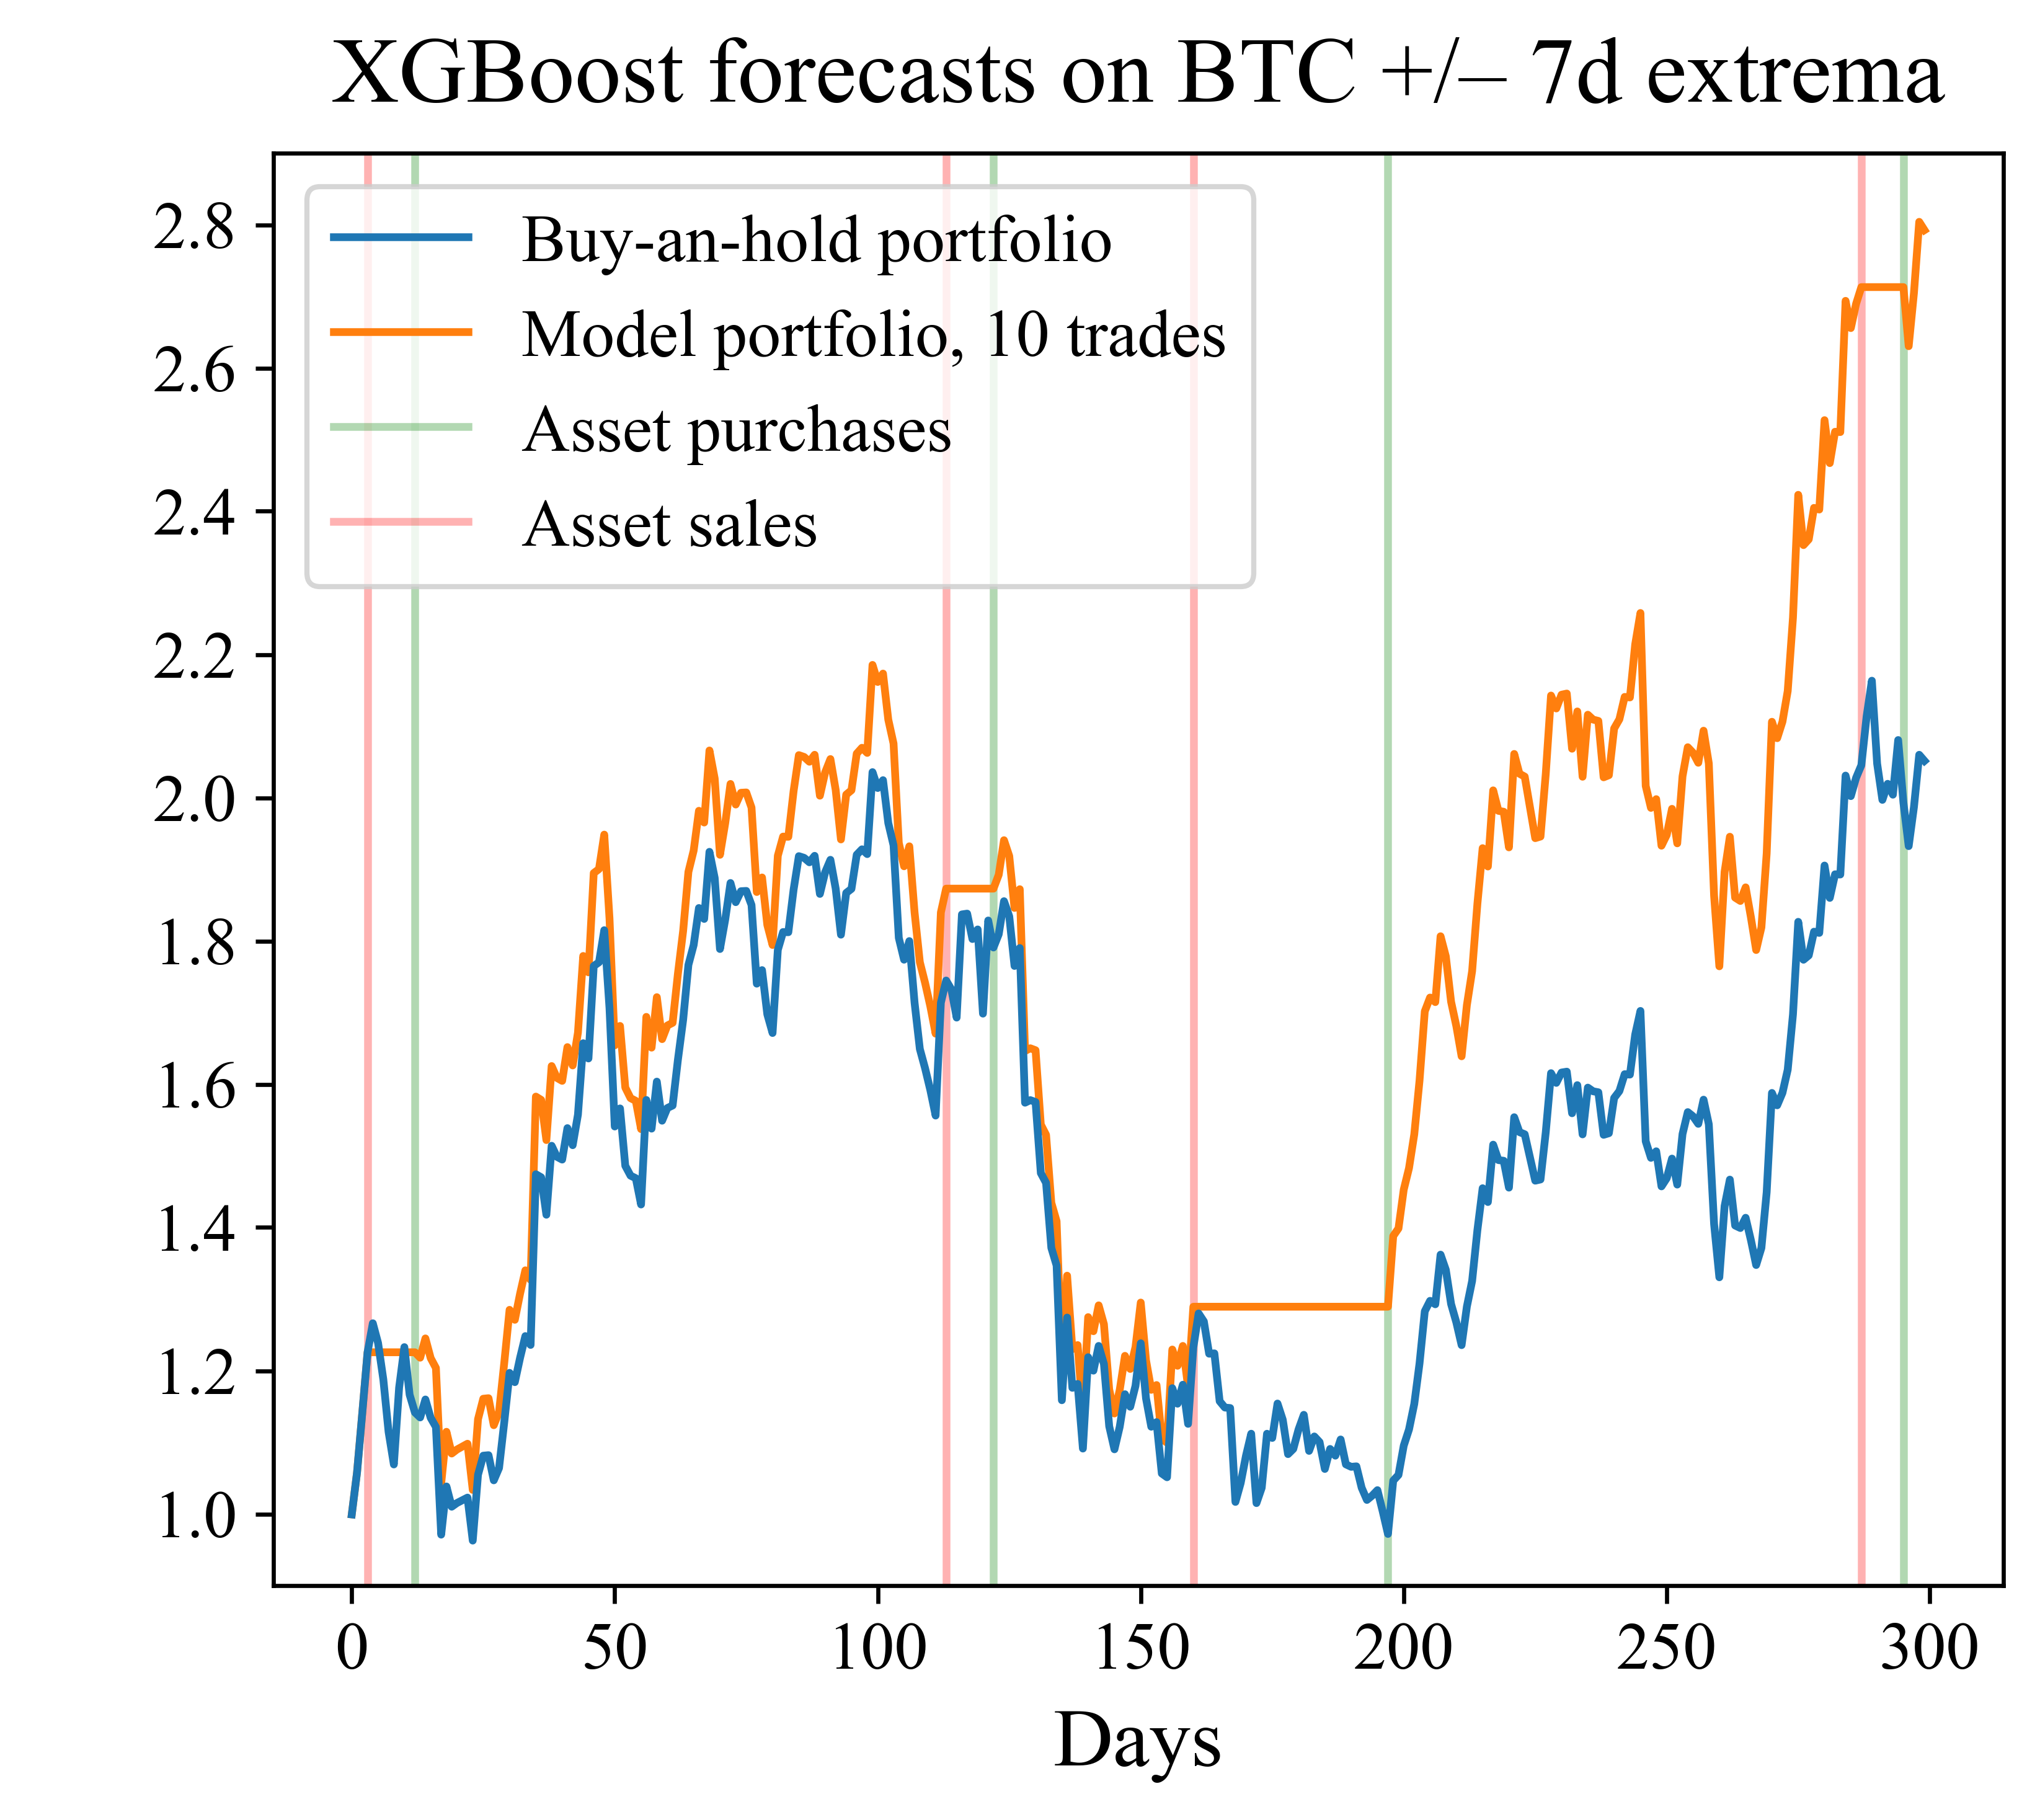

In [30]:
ax = plot_performace(price_data_test, y_pred, 'extrema')
plt.title(f'XGBoost forecasts on BTC +/– {timeframe}d extrema', pad=10)

# reposition legend
legend = ax.get_legend()
handles, labels = legend.legendHandles, [t.get_text() for t in legend.get_texts()]
ax.legend(handles=handles, labels=labels, loc='upper left')

loc = plticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.set_ylim(0.9, 2.9)

ax.yaxis.label.set_color('w') # remove y-axis label for the double-plot in the final paper
plt.show()